## Imports


In [66]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import pydot
import graphviz
import keras
import tensorflow_addons as tfa
import random
from IPython.display import clear_output
import time

## Preprocessing the Data

### Load Data

In [67]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = unpickle(f'./Data/data_batch_1')
labels = data[b'labels']
images = data[b'data']
for i in range(2,6):
    data = unpickle(f'./Data/data_batch_{i}')
    labels = np.concatenate((labels, data[b'labels']))
    images = np.concatenate((images,data[b'data']))
data_test = unpickle(f'./Data/test_batch')

labels_test = data_test[b'labels']
images_test = data_test[b'data']
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images.shape

(50000, 3072)

### Reshape Data

In [68]:
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)
images_test = images_test.reshape(len(images_test),3,32,32).transpose(0,2,3,1)
images.shape

(50000, 32, 32, 3)

### Visualize Some Data

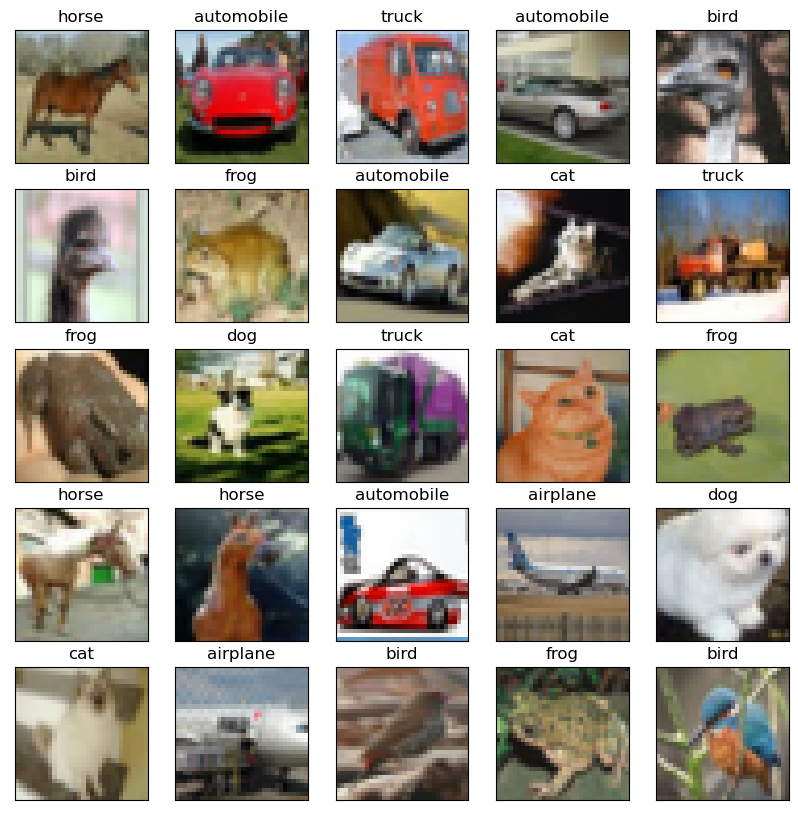

In [69]:
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images_to_show = images[imageId]
# take labels for these images only
labels_to_show = [labels[i] for i in imageId]

# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images_to_show[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels_to_show[i-1]]))
plt.show()

### Image Augmentation

#### Define Augmentation Steps in Augmenting Function

In [70]:
def random_augment_image(image):
    aug_image = tf.image.random_flip_left_right(image)
    aug_image = tf.image.random_flip_up_down(aug_image)
    aug_image = tf.image.random_brightness(aug_image, 0.2).numpy()
    return aug_image

#### Create Augmented Dataset

In [71]:
augmented_images_with_labels = []
for i, image in enumerate(images):
    if i%100 == 0:
        clear_output()
        print(i)
    label = labels[i]
    aug_image_1 = random_augment_image(image)
    aug_image_2 = random_augment_image(image)
    aug_image_1 = np.append(aug_image_1, label)
    aug_image_2 = np.append(aug_image_2, label)
    augmented_images_with_labels.extend([aug_image_1, aug_image_2])
np.random.shuffle(augmented_images_with_labels)
augmented_images_with_labels = np.array(augmented_images_with_labels)
print(augmented_images_with_labels.shape)
    

49900
(100000, 3073)


#### Separate Labels From Images

In [72]:
augmented_labels = augmented_images_with_labels[:,-1]
augmented_images = augmented_images_with_labels[:,:-1]

#### Reshape Augmented Images

In [73]:
augmented_images = augmented_images.reshape(len(augmented_images),32,32,3)
augmented_images.shape

(100000, 32, 32, 3)

#### Visualize Augmented Images

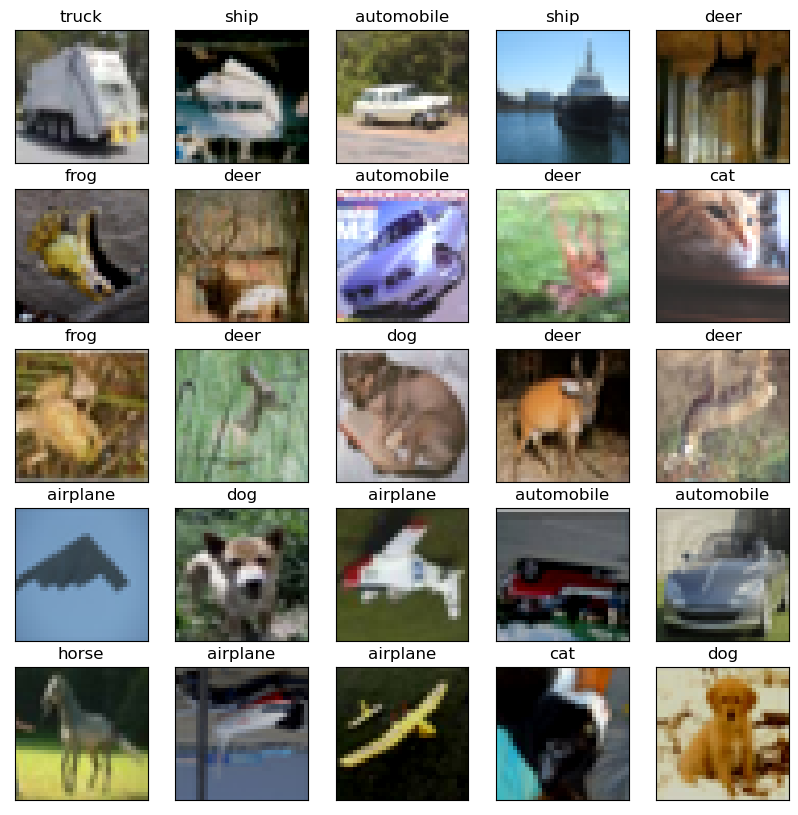

In [75]:
rows, columns = 5, 5
imageId = np.random.randint(0, len(augmented_images), rows * columns)
images_to_show = augmented_images[imageId]
labels_to_show = [augmented_labels[i] for i in imageId]
fig=plt.figure(figsize=(10, 10))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images_to_show[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}".format(label_names[labels_to_show[i-1]]))
plt.show()

## Custom ResNet Model Definition

### Residual Block Definition

In [76]:
def residual_block(X, num_filters: int, stride: int = 1, kernel_size: int = 3,
                   activation: str = 'relu', bn: bool = True, conv_first: bool = True):
    """
    Parameters
    ----------
    X : Tensor layer
        Input tensor from previous layer
    num_filters : int
        Conv2d number of filters
    stride : int by default 1
        Stride square dimension
    kernel_size : int by default 3
        COnv2D square kernel dimensions
    activation: str by default 'relu'
        Activation function to used
    bn: bool by default True
        To use BatchNormalization
    conv_first : bool by default True
        conv-bn-activation (True) or bn-activation-conv (False)
    """
    conv_layer = tf.keras.layers.Conv2D(num_filters,
                        kernel_size=kernel_size,
                        strides=stride,
                        padding='same',
                        kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001))
    # X = input
    if conv_first:
        X = conv_layer(X)
        if bn:
            X = tf.keras.layers.BatchNormalization()(X)
        if activation is not None:
            X = tf.keras.layers.Activation(activation)(X)
            X = tf.keras.layers.Dropout(0.2)(X)
    else:
        if bn:
            X = tf.keras.layers.BatchNormalization()(X)
        if activation is not None:
            X = tf.keras.layers.Activation(activation)(X)
        X = conv_layer(X)

    return X

### Full Model Definition

In [77]:
depth = 11
input_shape = [32, 32, 3]
num_filters_in = 32
num_classes = 10
def create_resnet(depth = depth, input_shape = input_shape, num_filters_in = num_filters_in, num_classes = num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    num_res_block = int((depth - 2) / 9)
    # ResNet V2 performs Conv2D on X before spiting into two path
    X = residual_block(X=inputs, num_filters=num_filters_in, conv_first=True)

    # Building stack of residual units
    for stage in range(3):
        for unit_res_block in range(num_res_block):
            activation = 'relu'
            bn = True
            stride = 1
            # First layer and first stage
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if unit_res_block == 0:
                    activation = None
                    bn = False
                # First layer but not first stage
            else:
                num_filters_out = num_filters_in * 2
                if unit_res_block == 0:
                    stride = 2

            # bottleneck residual unit
            y = residual_block(X,
                               num_filters=num_filters_in,
                               kernel_size=1,
                               stride=stride,
                               activation=activation,
                               bn=bn,
                               conv_first=False)
            y = residual_block(y,
                               num_filters=num_filters_in,
                               conv_first=False)
            y = residual_block(y,
                               num_filters=num_filters_out,
                               kernel_size=1,
                               conv_first=False)
            if unit_res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                X = residual_block(X=X,
                                   num_filters=num_filters_out,
                                   kernel_size=1,
                                   stride=stride,
                                   activation=None,
                                   bn=False)
            X = tf.keras.layers.add([X, y])
        num_filters_in = num_filters_out

    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.AveragePooling2D(pool_size=8)(X)
    y = tf.keras.layers.Flatten()(X)
    y = tf.keras.layers.Dense(512, activation='relu')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.5)(y)

    outputs = tf.keras.layers.Dense(num_classes,
                    activation='softmax')(y)

    # Instantiate model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

### Model Summary

In [78]:
model_11L = create_resnet()
model_11L.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_26 (Conv2D)             (None, 32, 32, 32)   896         ['input_22[0][0]']               
                                                                                                  
 batch_normalization_22 (BatchN  (None, 32, 32, 32)  128         ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 32, 32, 32)   0           ['batch_normalization_22[0

                                                                                                  
 add_8 (Add)                    (None, 8, 8, 512)    0           ['conv2d_38[0][0]',              
                                                                  'conv2d_37[0][0]']              
                                                                                                  
 batch_normalization_31 (BatchN  (None, 8, 8, 512)   2048        ['add_8[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 activation_29 (Activation)     (None, 8, 8, 512)    0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 average_pooling2d_2 (AveragePo  (None, 1, 1, 512)   0           ['activation_29[0][0]']          
 oling2D) 

### Compile Model

In [79]:
model_11L.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='SGD',
    metrics=['accuracy']
)

## Train Model

In [ ]:
model_11L.fit(x = augmented_images, y = np.array(augmented_labels), epochs = 20,
              validation_data = (images_test, np.array(labels_test)))

## Save Model

In [ ]:
tf.saved_model.save(model_11L, 'custom11Lresnet/1/')

## Semi-Pretrained Resnet50 Definition

In [52]:
def feature_extractor(inputs):

    feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
    return feature_extractor


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x
def final_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    
    resnet = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
    resnet.trainable = False
    
    feature_extractor = resnet(resize, training = False)
    classification_output = classifier(feature_extractor)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
    return model




### Instantiate Model

In [53]:
model_pretrained = final_model()
model_pretrained.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

In [54]:
model_pretrained.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_10 (UpSamplin  (None, 224, 224, 3)      0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               1049

In [ ]:
model_pretrained.fit(x = augmented_images, y = np.array(augmented_labels), 
              epochs = 20, validation_data = (images_test, np.array(labels_test)))


In [ ]:
tf.saved_model.save(model_pretrained, 'pretrainedResNet50/1/')